<a href="https://colab.research.google.com/github/abdelkadergelany/Intrusion-Detection-in-IoT-Based-Network/blob/main/Complete_model_WIth_63_perct_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# sklearn: data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder ,MinMaxScaler

# sklearn: train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

#Feature selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import xgboost, lightgbm


# Data Processing

## Load Data

**UNSW-NB15: a comprehensive data set for network intrusion detection systems**


attack_cat: This dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms.

Label: 0 for normal and 1 for attack records


In [24]:
# Load data
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [25]:
# Look at the first 5 rows
combined_data.head(n=5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [27]:
# information of the data: 
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 82331
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  din


### Check missing values
First, we should check if there are missing values in the dataset.

In [28]:
# check if there are Null values
combined_data.isnull().sum()

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
label      

A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. Actually, there exists some strategies to impute missing values (see [here](https://scikit-learn.org/stable/modules/impute.html)).

In [29]:
# Discard the rows with missing values

data_to_use = combined_data.dropna()

# Shape of the data: we could see that the number of rows remains the same as no null values were reported
data_to_use.shape

(257673, 44)

<h1>Contamination mean pollution (outliers) in data</h1>

In [30]:
# Contaminsation mean pollution (outliers) in data
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.68
test  contamination  0.55 

contamination is 0.68, which is greater than 0.5. Fixing...
contamination is now 0.32


### Check imbalanced issue on y

First, we get the `X` and `y1` and `y2` .

In [ ]:
# X = data_to_use.drop(axis=1, columns=['attack_cat']) # X is a dataframe
# X = X.drop(axis=1, columns=['label'])


# y1 = data_to_use['attack_cat'].values # y is an array
# y2 = data_to_use['label'].values

# #We will convert the orginal training data to the datframes called X_train, y1_train, y2_train

# X_train = X
# y1_train = y1
# y2_train = y2

<h1>Encoding non numeric Values</h1>

In [31]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")

attack cat: {'DoS', 'Analysis', 'Shellcode', 'Reconnaissance', 'Fuzzers', 'Backdoor', 'Worms', 'Normal', 'Generic', 'Exploits'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int64 Which is, ['Normal']
mode 0.3609225646458884 %


<h1>Spliting the dataset</h1>

In [32]:
data_x = combined_data.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data.loc[:,['label']]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.20, random_state=42) 

In [ ]:
y_train.head(3)

<h1>Feature selection with CHi2</h1>

In [11]:
#Feature selection

chi2_selector = SelectKBest(chi2, k=14)
X_train_kbest = chi2_selector.fit_transform(X_train, y_train)
X_test_kbest = chi2_selector.fit_transform(X_test, y_test)

#print(X_kbest.shape)
# X_train_transform = X_train_kbest
# X_test_transform = X_test_kbest
X_train = X_train_kbest
X_test = X_test_kbest


In [33]:
# Calculate Y2 ratio
def data_ratio(y2):
    '''
    Calculate Y2's ratio
    '''
    unique, count = np.unique(y2, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

In [34]:
combined_data = pd.concat([train, test]).drop(['id'],axis=1)
attacks_type = combined_data['attack_cat'].values
class_type = combined_data['label'].values

The class ratio for the original data: 1.1:1 (2677/2329)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


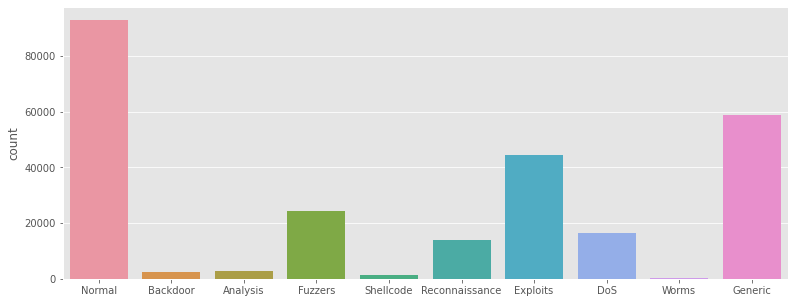

The class ratio for the original data: 0.6:1 (93000/164673)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


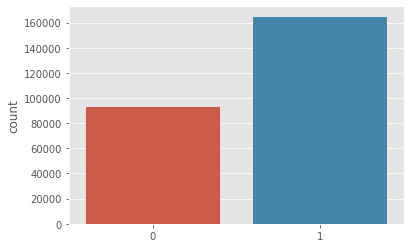

In [35]:
print('The class ratio for the original data:', data_ratio(attacks_type))
plt.figure(figsize=(13,5))
sns.countplot(attacks_type,label="Sum")
plt.show()

print('The class ratio for the original data:', data_ratio(class_type))
sns.countplot(class_type,label="Sum")
plt.show()

We could see that the dataset is not perfectly balanced. There are some sampling techniques to deal with this issue. Here, we ignore this issue because we are aimed to implement several ML models to compare their performance. 

# Train ML Models

We will train several machine learning models for the training set and evaluate their performance on both training and testing set.This will helps us to choose the best Supervised algorithm.




In [108]:
# y_train = y_train['label'].values
# y_test = y_test['label'].values

In [ ]:
# ===== Step 1: cross-validation ========
# define a Logistic Regression classifier
clf = LogisticRegression(solver='lbfgs', random_state=123, max_iter = 4000)

# define  Stratified 5-fold cross-validator, it provides train/validate indices to split data in train/validate sets.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# define metrics for evaluating
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# perform the 5-fold CV and get the metrics results
cv_results = cross_validate(estimator=clf,
                            X=X_train,
                            y=y_train,
                            scoring=scoring,
                            cv=cv,
                            return_train_score=False)

In [19]:
cv_results['test_accuracy'].mean()

0.8070273373673642

## Several ML Models

We will implement several ML models through the above steps. The only difference part is to change `clf = LogisticRegression()` as other model functions, for example, `clf = DecisionTreeClassifier()`. 

The followings are ML models functions: 

- `LogisticRegression()`
- `DecisionTreeClassifier()`
- `RandomForestClassifier()`
- `MLPClassifier()`

Note that in `MLPClassifier()` we set the solver as `lbfgs` which has better performance for small size of data. Also, we set the maximum iterations as 5000 to ensure convergence. `random_state` is used to ensure reproducible results.

In [20]:
# Define four models
models = [('LogisticRegression', LogisticRegression(random_state=123, max_iter=5000)),
          ('DecisionTree', DecisionTreeClassifier(random_state=123)),
          ('RandomForest', RandomForestClassifier(random_state=123)),
          ('MultiLayerPerceptron', MLPClassifier(random_state=123, solver='adam', max_iter=8000)),
           ('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1))
         ]

We could check the hyperparameters values in these models: 

In [ ]:
for model_name, clf in models:
    print(clf)

In [36]:
y_train_copy = y_train['label'].values
y_test_copy = y_test['label'].values

**Finally, we write the code to perform the above four ML models and store their cross-validation results and evaluation results on testing data.**

<h1>#Test our candidate algorithms
<h1>

In [37]:
#Test our candidates algorithm
# DTC = DecisionTreeClassifier()
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500) # multiclass

list_of_CLFs_names = []
list_of_CLFs = [ RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train_copy)
    pred = clf.score(X_test,y_test_copy)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.95240 for the RandomForestClassifier
Acc: 0.95133 for the ExtraTreesClassifier
Acc: 0.93653 for the XGBClassifier
Acc: 0.95269 for the LGBMClassifier


In [ ]:
# define several lists and dataframe to store the CV results and evaluation results on testing data
model_names_list = []
cv_fit_time_mean_list = []
cv_accuracy_mean_list = []
cv_precision_mean_list = []
cv_recall_mean_list = []
cv_f1_mean_list = []
cv_roc_auc_mean_list = []

test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_roc_auc_list = []

test_roc_curve_df = pd.DataFrame()


for model_name, clf in models:
    
    # ==== Step 1: Cross-validation =====
    
    # define  Stratified 5-fold cross-validator
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    # define metrics for evaluating
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    # perform the 5-fold CV and get the metrics results
    cv_results = cross_validate(estimator=clf,
                                X=X_train,
                                y=y_train,
                                scoring=scoring,
                                cv=cv,
                                return_train_score=False)  # prevent to show the train scores on cv splits.

    # calculate the mean values of those scores
    cv_fit_time_mean = cv_results['fit_time'].mean()
    cv_accuracy_mean = cv_results['test_accuracy'].mean()
    cv_precision_mean = cv_results['test_precision'].mean()
    cv_recall_mean = cv_results['test_recall'].mean()
    cv_f1_mean = cv_results['test_f1'].mean()
    cv_roc_auc_mean = cv_results['test_roc_auc'].mean()

    # store CV results into those lists
    model_names_list.append(model_name)
    cv_fit_time_mean_list.append(cv_fit_time_mean)
    cv_accuracy_mean_list.append(cv_accuracy_mean)
    cv_precision_mean_list.append(cv_precision_mean)
    cv_recall_mean_list.append(cv_recall_mean)
    cv_f1_mean_list.append(cv_f1_mean)
    cv_roc_auc_mean_list.append(cv_roc_auc_mean)

    # ==== Step 2: Evaluation on Testing data =====

    # fit model
    clf.fit(X=X_train, y=y_train)

    # predition on testing data
    
    # predicted label or class
    y_pred_class = clf.predict(X=X_test)  
    
    # predicted probability of the label 1
    y_pred_score = clf.predict_proba(X=X_test)[:, 1]

    # accuracy
    accuracy_ontest = accuracy_score(y_true=y_test, y_pred=y_pred_class)
    
    # auc of ROC
    auc_ontest = roc_auc_score(y_true=y_test, y_score=y_pred_score)
    
    # precision score
    precision_ontest = precision_score(y_true=y_test, y_pred=y_pred_class)
    
    # recall score
    recall_ontest = recall_score(y_true=y_test, y_pred=y_pred_class)
    
    # F1 score
    f1_ontest = f1_score(y_true=y_test, y_pred=y_pred_class)
    
    # roc curve dataframe
    fpr, tpr, threshold_roc = roc_curve(y_true=y_test, y_score=y_pred_score)
    
    roc_df = pd.DataFrame(list(zip(fpr, tpr, threshold_roc)),
                          columns=['False Positive Rate', 'True Positive Rate', 'Threshold'])
    
    roc_df['Model'] = '{} (AUC = {:.3f})'.format(model_name, auc_ontest)


    # store the above values
    test_accuracy_list.append(accuracy_ontest)
    test_roc_auc_list.append(auc_ontest)
    test_precision_list.append(precision_ontest)
    test_recall_list.append(recall_ontest)
    test_f1_list.append(f1_ontest)
    
    test_roc_curve_df = pd.concat([test_roc_curve_df, roc_df],
                                 ignore_index=True)

### Model Comparison

We've stored CV results and evaluation results of testing data for the four ML models. Then, we could create a dataframe to view them.

In [ ]:
results_dict = {'Model Name': model_names_list,
                'CV Fit Time': cv_fit_time_mean_list,
                'CV Accuracy mean': cv_accuracy_mean_list,
                'CV Precision mean': cv_precision_mean_list,
                'CV Recall mean': cv_recall_mean_list,
                'CV F1 mean': cv_f1_mean_list,
                'CV AUC mean': cv_roc_auc_mean_list,
                'Test Accuracy': test_accuracy_list,
                'Test Precision': test_precision_list,
                'Test Recall': test_recall_list,
                'Test F1': test_f1_list,
                'Test AUC': test_roc_auc_list
                }

results_df = pd.DataFrame(results_dict)

# sort the results according to F1 score on testing data
results_df.sort_values(by='Test F1', ascending=False)

<h1>Choice of the Best algorithm</h1>

In [38]:
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
RFC.fit(X_train,y_train_copy) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

<h1>Testing the performance of the Best algorithm on test dataset</h1>

In [ ]:
X_test

In [40]:
#predict the class label with the selected algorithm
New_X_test = X_test
New_X_test['sign_deciscion']= RFC.predict(New_X_test)
New_X_test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(51535, 43)

In [41]:
#store the predicted lable 
deciscion = pd.DataFrame(New_X_test['sign_deciscion'])
deciscion

,sign_deciscion
122637,1
137118,1
69948,0
45921,1
31408,0
...,...
10687,1
120658,1
61193,1
35810,0


In [60]:
#Remove the added column
X_test = X_test.drop(['sign_deciscion'], axis=1)
X_test.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.516800,0.001000,13675.729750,0.000000,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0
45921,0.486485,113,5,4,10,8,798,1568,34.944551,62,252,1.182359e+04,22561.845700,2,2,54.053889,59.958430,2705.531092,82.549047,255,101844950,785426226,255,0.138611,0.065983,0.072628,80,196,1,372,1,1,1,1,1,1,0,0,1,1,1,0
31408,0.072147,119,0,2,4,4,568,312,97.024136,31,29,4.723689e+04,25947.025390,0,0,18.674334,23.547666,26.397475,33.299309,0,0,0,0,0.000000,0.000000,0.000000,142,78,0,0,7,0,5,1,1,5,0,0,0,2,8,0


<h1>Unsupervied ML (Anomaly)</h1>

In [42]:
%%capture 
!pip install pyod
!pip install hdbscan
!pip install combo
!pip install SOM...... # https://github.com/AICoE/log-anomaly-detector/blob/master/Notebooks/SOM_retrain_notebook/SOM_UserFeedbackPOC.ipynb
!pip install somtf

In [43]:
!pip install rrcf

In [44]:
import gc, os, pickle
from datetime import datetime

import numpy as np
import pandas as pd
from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pyod
from hdbscan import HDBSCAN
import rrcf

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import * 
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.metrics import  precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report


In [45]:
from pyod.models import lof, cblof, cof, pca, iforest, knn, mcd, ocsvm, sod, abod, hbos #, auto_encoder, vae
contamination = 0.4
threshold = 0.75

<table class="docutils align-default">
<colgroup>
<col style="width: 8%">
<col style="width: 6%">
<col style="width: 41%">
<col style="width: 2%">
<col style="width: 21%">
<col style="width: 22%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Type</p></th>
<th class="head"><p>Abbr</p></th>
<th class="head"><p>Algorithm</p></th>
<th class="head"><p>Year</p></th>
<th class="head"><p>Class</p></th>
<th class="head"><p>Ref</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>Linear Model</p></td>
<td><p>PCA</p></td>
<td><p>Principal Component Analysis (the sum of weighted projected distances to the eigenvector hyperplanes)</p></td>
<td><p>2003</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.pca.PCA" title="pyod.models.pca.PCA"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.pca.PCA</span></code></a></p></td>
<td><p><span id="id3">[<a class="reference internal" href="#id53"><span>ASCSC03</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Linear Model</p></td>
<td><p>MCD</p></td>
<td><p>Minimum Covariance Determinant (use the mahalanobis distances as the outlier scores)</p></td>
<td><p>1999</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.mcd.MCD" title="pyod.models.mcd.MCD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.mcd.MCD</span></code></a></p></td>
<td><p><span id="id4">[<a class="reference internal" href="#id57"><span>ARD99</span></a>,<a class="reference internal" href="#id58"><span>AHR04</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Linear Model</p></td>
<td><p>OCSVM</p></td>
<td><p>One-Class Support Vector Machines</p></td>
<td><p>2001</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.ocsvm.OCSVM" title="pyod.models.ocsvm.OCSVM"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.ocsvm.OCSVM</span></code></a></p></td>
<td><p><span id="id5">[<a class="reference internal" href="#id68"><span>AScholkopfPST+01</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Linear Model</p></td>
<td><p>LMDD</p></td>
<td><p>Deviation-based Outlier Detection (LMDD)</p></td>
<td><p>1996</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.lmdd.LMDD" title="pyod.models.lmdd.LMDD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.lmdd.LMDD</span></code></a></p></td>
<td><p><span id="id6">[<a class="reference internal" href="#id75"><span>AAAR96</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>LOF</p></td>
<td><p>Local Outlier Factor</p></td>
<td><p>2000</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.lof.LOF" title="pyod.models.lof.LOF"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.lof.LOF</span></code></a></p></td>
<td><p><span id="id7">[<a class="reference internal" href="#id55"><span>ABKNS00</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>COF</p></td>
<td><p>Connectivity-Based Outlier Factor</p></td>
<td><p>2002</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.cof.COF" title="pyod.models.cof.COF"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.cof.COF</span></code></a></p></td>
<td><p><span id="id8">[<a class="reference internal" href="#id69"><span>ATCFC02</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>CBLOF</p></td>
<td><p>Clustering-Based Local Outlier Factor</p></td>
<td><p>2003</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.cblof.CBLOF" title="pyod.models.cblof.CBLOF"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.cblof.CBLOF</span></code></a></p></td>
<td><p><span id="id9">[<a class="reference internal" href="#id59"><span>AHXD03</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>LOCI</p></td>
<td><p>LOCI: Fast outlier detection using the local correlation integral</p></td>
<td><p>2003</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.loci.LOCI" title="pyod.models.loci.LOCI"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.loci.LOCI</span></code></a></p></td>
<td><p><span id="id10">[<a class="reference internal" href="#id62"><span>APKGF03</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>HBOS</p></td>
<td><p>Histogram-based Outlier Score</p></td>
<td><p>2012</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.hbos.HBOS" title="pyod.models.hbos.HBOS"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.hbos.HBOS</span></code></a></p></td>
<td><p><span id="id11">[<a class="reference internal" href="#id52"><span>AGD12</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>kNN</p></td>
<td><p>k Nearest Neighbors (use the distance to the kth nearest neighbor as the outlier score</p></td>
<td><p>2000</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.knn.KNN" title="pyod.models.knn.KNN"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.knn.KNN</span></code></a></p></td>
<td><p><span id="id12">[<a class="reference internal" href="#id48"><span>ARRS00</span></a>,<a class="reference internal" href="#id49"><span>AAP02</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>AvgKNN</p></td>
<td><p>Average kNN (use the average distance to k nearest neighbors as the outlier score)</p></td>
<td><p>2002</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.knn.KNN" title="pyod.models.knn.KNN"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.knn.KNN</span></code></a></p></td>
<td><p><span id="id13">[<a class="reference internal" href="#id48"><span>ARRS00</span></a>,<a class="reference internal" href="#id49"><span>AAP02</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>MedKNN</p></td>
<td><p>Median kNN (use the median distance to k nearest neighbors as the outlier score)</p></td>
<td><p>2002</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.knn.KNN" title="pyod.models.knn.KNN"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.knn.KNN</span></code></a></p></td>
<td><p><span id="id14">[<a class="reference internal" href="#id48"><span>ARRS00</span></a>,<a class="reference internal" href="#id49"><span>AAP02</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Proximity-Based</p></td>
<td><p>SOD</p></td>
<td><p>Subspace Outlier Detection</p></td>
<td><p>2009</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.sod.SOD" title="pyod.models.sod.SOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.sod.SOD</span></code></a></p></td>
<td><p><span id="id15">[<a class="reference internal" href="#id71"><span>AKKrogerSZ09</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Proximity-Based</p></td>
<td><p>ROD</p></td>
<td><p>Rotation-based Outlier Detection</p></td>
<td><p>2020</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.rod.ROD" title="pyod.models.rod.ROD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.rod.ROD</span></code></a></p></td>
<td><p><span id="id16">[<a class="reference internal" href="#id81"><span>AABC20</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Probabilistic</p></td>
<td><p>ABOD</p></td>
<td><p>Angle-Based Outlier Detection</p></td>
<td><p>2008</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.abod.ABOD" title="pyod.models.abod.ABOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.abod.ABOD</span></code></a></p></td>
<td><p><span id="id17">[<a class="reference internal" href="#id50"><span>AKZ+08</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Probabilistic</p></td>
<td><p>FastABOD</p></td>
<td><p>Fast Angle-Based Outlier Detection using approximation</p></td>
<td><p>2008</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.abod.ABOD" title="pyod.models.abod.ABOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.abod.ABOD</span></code></a></p></td>
<td><p><span id="id18">[<a class="reference internal" href="#id50"><span>AKZ+08</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Probabilistic</p></td>
<td><p>COPOD</p></td>
<td><p>COPOD: Copula-Based Outlier Detection</p></td>
<td><p>2020</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.copod.COPOD" title="pyod.models.copod.COPOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.copod.COPOD</span></code></a></p></td>
<td><p><span id="id19">[<a class="reference internal" href="#id80"><span>ALZB+20</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Probabilistic</p></td>
<td><p>MAD</p></td>
<td><p>Median Absolute Deviation (MAD)</p></td>
<td><p>1993</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.mad.MAD" title="pyod.models.mad.MAD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.mad.MAD</span></code></a></p></td>
<td><p><span id="id20">[<a class="reference internal" href="#id79"><span>AIH93</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Probabilistic</p></td>
<td><p>SOS</p></td>
<td><p>Stochastic Outlier Selection</p></td>
<td><p>2012</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.sos.SOS" title="pyod.models.sos.SOS"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.sos.SOS</span></code></a></p></td>
<td><p><span id="id21">[<a class="reference internal" href="#id61"><span>AJHuszarPvdH12</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Outlier Ensembles</p></td>
<td><p>IForest</p></td>
<td><p>Isolation Forest</p></td>
<td><p>2008</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.iforest.IForest" title="pyod.models.iforest.IForest"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.iforest.IForest</span></code></a></p></td>
<td><p><span id="id22">[<a class="reference internal" href="#id44"><span>ALTZ08</span></a>,<a class="reference internal" href="#id45"><span>ALTZ12</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Outlier Ensembles</p></td>
<td></td>
<td><p>Feature Bagging</p></td>
<td><p>2005</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.feature_bagging.FeatureBagging" title="pyod.models.feature_bagging.FeatureBagging"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.feature_bagging.FeatureBagging</span></code></a></p></td>
<td><p><span id="id23">[<a class="reference internal" href="#id51"><span>ALK05</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Outlier Ensembles</p></td>
<td><p>LSCP</p></td>
<td><p>LSCP: Locally Selective Combination of Parallel Outlier Ensembles</p></td>
<td><p>2019</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.lscp.LSCP" title="pyod.models.lscp.LSCP"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.lscp.LSCP</span></code></a></p></td>
<td><p><span id="id24">[<a class="reference internal" href="#id63"><span>AZNHL19</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Outlier Ensembles</p></td>
<td><p>XGBOD</p></td>
<td><p>Extreme Boosting Based Outlier Detection <strong>(Supervised)</strong></p></td>
<td><p>2018</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.xgbod.XGBOD" title="pyod.models.xgbod.XGBOD"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.xgbod.XGBOD</span></code></a></p></td>
<td><p><span id="id25">[<a class="reference internal" href="#id56"><span>AZH18</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Outlier Ensembles</p></td>
<td><p>LODA</p></td>
<td><p>Lightweight On-line Detector of Anomalies</p></td>
<td><p>2016</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.loda.LODA" title="pyod.models.loda.LODA"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.loda.LODA</span></code></a></p></td>
<td><p><span id="id26">[<a class="reference internal" href="#id77"><span>APevny16</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Neural Networks</p></td>
<td><p>AutoEncoder</p></td>
<td><p>Fully connected AutoEncoder (use reconstruction error as the outlier score)</p></td>
<td><p>2015</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.auto_encoder.AutoEncoder" title="pyod.models.auto_encoder.AutoEncoder"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.auto_encoder.AutoEncoder</span></code></a></p></td>
<td><p><span id="id27">[<a class="reference internal" href="#id54"><span>AAgg15</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Neural Networks</p></td>
<td><p>VAE</p></td>
<td><p>Variational AutoEncoder (use reconstruction error as the outlier score)</p></td>
<td><p>2013</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.vae.VAE" title="pyod.models.vae.VAE"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.vae.VAE</span></code></a></p></td>
<td><p><span id="id28">[<a class="reference internal" href="#id76"><span>AKW13</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Neural Networks</p></td>
<td><p>Beta-VAE</p></td>
<td><p>Variational AutoEncoder (all customized loss term by varying gamma and capacity)</p></td>
<td><p>2018</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.vae.VAE" title="pyod.models.vae.VAE"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.vae.VAE</span></code></a></p></td>
<td><p><span id="id29">[<a class="reference internal" href="#id78"><span>ABHP+18</span></a>]</span></p></td>
</tr>
<tr class="row-odd"><td><p>Neural Networks</p></td>
<td><p>SO_GAAL</p></td>
<td><p>Single-Objective Generative Adversarial Active Learning</p></td>
<td><p>2019</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.so_gaal.SO_GAAL" title="pyod.models.so_gaal.SO_GAAL"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.so_gaal.SO_GAAL</span></code></a></p></td>
<td><p><span id="id30">[<a class="reference internal" href="#id64"><span>ALLZ+19</span></a>]</span></p></td>
</tr>
<tr class="row-even"><td><p>Neural Networks</p></td>
<td><p>MO_GAAL</p></td>
<td><p>Multiple-Objective Generative Adversarial Active Learning</p></td>
<td><p>2019</p></td>
<td><p><a class="reference internal" href="pyod.models.html#pyod.models.mo_gaal.MO_GAAL" title="pyod.models.mo_gaal.MO_GAAL"><code class="xref py py-class docutils literal notranslate"><span class="pre">pyod.models.mo_gaal.MO_GAAL</span></code></a></p></td>
<td><p><span id="id31">[<a class="reference internal" href="#id64"><span>ALLZ+19</span></a>]</span></p></td>
</tr>
</tbody>
</table>

## Uses PYOD

<h1><b>Printing Score metrics</b></h1>

In [51]:
def PrintScoreMetrics(algorithm,X_test,y_test):
    y_pred_class = algorithm.predict(X_test)
    y_pred_score = algorithm.predict_proba(X=X_test)[:, 1]


    # AUC of ROC
    auc_ontest = roc_auc_score(y_true=y_test, y_score=y_pred_score)
    # confusion matrix
    cm_ontest = confusion_matrix(y_true=y_test, y_pred=y_pred_class)
    # precision score
    precision_ontest = precision_score(y_true=y_test, y_pred=y_pred_class)
    # recall score
    recall_ontest = recall_score(y_true=y_test, y_pred=y_pred_class)
    # classifition report
    cls_report_ontest = classification_report(y_true=y_test, y_pred=y_pred_class)

    # print the above results
    print('The model scores {:1.5f} ROC AUC on the test set.'.format(auc_ontest))
    print('The precision score on the test set: {:1.5f}'.format(precision_ontest))
    print('The recall score on the test set: {:1.5f}'.format(recall_ontest))
    print('Confusion Matrix:\n', cm_ontest)
    # Print classification report:
    print('Classification Report:\n', cls_report_ontest)

<h1><b>the LOF model</b><h1>

In [49]:
#===============TRAIN THE LOF MODEL ======================
lof_clf = lof.LOF(contamination=contamination, n_jobs=-1)
_ = lof_clf.fit(X_train)


In [61]:
#======= EVALUATE LOF MODEL =================
PrintScoreMetrics(lof_clf,X_test,y_test)

The model scores 0.48922 ROC AUC on the test set.
The precision score on the test set: 0.59979
The recall score on the test set: 0.41124
Confusion Matrix:
 [[ 9579  9034]
 [19383 13539]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.51      0.40     18613
           1       0.60      0.41      0.49     32922

    accuracy                           0.45     51535
   macro avg       0.47      0.46      0.45     51535
weighted avg       0.50      0.45      0.46     51535



<h1><b>the CBLOF model</b><h1>

In [ ]:
#========== TRAIN CBLOF MODEL ==========
cblof_clf = cblof.CBLOF(contamination=contamination, n_jobs=-1, n_clusters=45)
_ = cblof_clf.fit(X_train)


In [ ]:
#======= EVALUATE CBLOF MODEL =================

PrintScoreMetrics(cblof_clf,X_test,y_test)


The model scores 0.35109 ROC AUC on the test set.
The precision score on the test set: 0.51854
The recall score on the test set: 0.32969
Confusion Matrix:
 [[ 8535 10078]
 [22068 10854]]
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.46      0.35     18613
           1       0.52      0.33      0.40     32922

    accuracy                           0.38     51535
   macro avg       0.40      0.39      0.37     51535
weighted avg       0.43      0.38      0.38     51535



<h1><b>the Connectivity-Based Outlier Factor (cof)</b><h1>

In [32]:
#========== TRAIN COF MODEL ==========

cof_clf = cof.COF(contamination=contamination) 
_ = cof_clf.fit(X_train[:5000])


In [ ]:
#======= EVALUATE COF MODEL =================

PrintScoreMetrics(cof_clf,X_test,y_test)


<h1><b>The PCA MODEL</b><h1>

In [ ]:
# https://pyod.readthedocs.io/en/latest/_modules/pyod/models/pca.html
#=============TRAINING PCA MODEL=========================
pca_clf = pca.PCA(contamination=contamination)
_ = pca_clf.fit(X_train)

In [ ]:
#======= EVALUATE PCA MODEL =================

PrintScoreMetrics(pca_clf,X_test,y_test)


In [ ]:
pca_clf = pca.PCA(2, contamination=contamination)
_ = pca_clf.fit(X_train)

PrintScoreMetrics(pca_clf,X_test,y_test)


<h1><b>The IFOREST MODEL</b><h1>

In [70]:
iforest_clf = iforest.IForest(contamination=contamination, n_estimators=300, max_samples= 1028, n_jobs=-1)
_ = iforest_clf.fit(X_train)


In [77]:
X_test.head(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.0050,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.0030,0.000,0.00000,0.0,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.5168,0.001,13675.72975,0.0,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0


In [72]:
#======= EVALUATE IFOREST MODEL =================

PrintScoreMetrics(iforest_clf,X_test,y_test)


The model scores 0.31911 ROC AUC on the test set.
The precision score on the test set: 0.49131
The recall score on the test set: 0.30651
Confusion Matrix:
 [[ 8165 10448]
 [22831 10091]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.44      0.33     18613
           1       0.49      0.31      0.38     32922

    accuracy                           0.35     51535
   macro avg       0.38      0.37      0.35     51535
weighted avg       0.41      0.35      0.36     51535



In [63]:
Anom_X_test = X_test
#Anom_X_test['scores']=iforest_clf.decision_function(X_test)
Anom_X_test['anom_deciscion']=lof_clf.predict(X_test)
Anom_X_test.head(5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,anom_deciscion
122637,0.000005,119,2,5,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,13,2,9,9,9,13,0,0,0,9,13,0,0
137118,0.000003,119,2,5,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,16,2,16,16,16,16,0,0,0,17,16,0,0
69948,1.167584,113,0,2,6,2,1012,86,5.995286,62,252,5.782882e+03,294.625488,2,1,233.516800,0.001000,13675.729750,0.000000,255,1497222707,3407537974,255,0.940009,0.560296,0.379713,169,43,0,0,2,3,1,1,1,2,0,0,0,2,2,0,1
45921,0.486485,113,5,4,10,8,798,1568,34.944551,62,252,1.182359e+04,22561.845700,2,2,54.053889,59.958430,2705.531092,82.549047,255,101844950,785426226,255,0.138611,0.065983,0.072628,80,196,1,372,1,1,1,1,1,1,0,0,1,1,1,0,1
31408,0.072147,119,0,2,4,4,568,312,97.024136,31,29,4.723689e+04,25947.025390,0,0,18.674334,23.547666,26.397475,33.299309,0,0,0,0,0.000000,0.000000,0.000000,142,78,0,0,7,0,5,1,1,5,0,0,0,2,8,0,1


In [64]:
 deciscion['anom_decision']  = pd.DataFrame(Anom_X_test['anom_deciscion'])


In [65]:
 Final_decision =  pd.DataFrame(columns=['Output'])


In [66]:
Final_decision.head(3)

,Output


In [67]:
deciscion.head(20)

,sign_deciscion,anom_decision
122637,1,0
137118,1,0
69948,0,1
45921,1,1
31408,0,1
92650,1,0
66839,1,0
123191,1,0
9754,1,0
169313,1,1


<h1>Find the accuracy of our model</h1>

In [68]:
for index, row in deciscion.iterrows():
    if((row['anom_decision']==1) and (row['sign_deciscion']== 1)):
        Final_decision.loc[index] = 1
    elif((row['anom_decision']==0) and (row['sign_deciscion']== 0)):
        Final_decision.loc[index] = 0
    elif((row['anom_decision']==1) and (row['sign_deciscion']== 0)):
        Final_decision.loc[index] = 1
    else:
      Final_decision.loc[index] = -1

In [69]:
#Final_decision.head(20)
pred_attack = Final_decision.where(Final_decision['Output'] == 1).dropna()
pred_attack.shape

(20982, 1)

In [70]:
true_attack = y_test.where(y_test['label'] == 1).dropna()
true_attack.shape

(32922, 1)

In [71]:
accuracy = len(pred_attack)/len(true_attack)
print(100* accuracy)

63.7324585383634


<h1><b>The KNN MODEL</b><h1>

In [ ]:
#========== TRAIN KNN MODEL ==========
knn_clf = knn.KNN(contamination=contamination, radius=1.5, n_neighbors=20, n_jobs=-1) #TODO radius
_ = knn_clf.fit(X_train)

# predictions = knn_clf.predict(X_train)
# print(f'Acc of train: {accuracy_score(y_train, predictions)}')
# predictions = knn_clf.predict(X_test)
# print(f'Acc of test: {accuracy_score(y_test, predictions)}')

In [ ]:
#======= EVALUATE KNN MODEL =================

PrintScoreMetrics(knn_clf,X_test,y_test)

The model scores 0.34280 ROC AUC on the test set.
The precision score on the test set: 0.55034
The recall score on the test set: 0.34649
Confusion Matrix:
 [[ 9293  9320]
 [21515 11407]]
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.50      0.38     18613
           1       0.55      0.35      0.43     32922

    accuracy                           0.40     51535
   macro avg       0.43      0.42      0.40     51535
weighted avg       0.46      0.40      0.41     51535



<h1><b>The OCSVM MODEL</b><h1>

In [74]:
#================== TRAIN OCSVM ===============================
ocsvm_clf = ocsvm.OCSVM(contamination=contamination)
_ = ocsvm_clf.fit(X_train[:1000])


In [76]:
#======= EVALUATE OCSVM MODEL =================

PrintScoreMetrics(ocsvm_clf,X_test,y_test)

The model scores 0.35861 ROC AUC on the test set.
The precision score on the test set: 0.62138
The recall score on the test set: 0.90973
Confusion Matrix:
 [[  364 18249]
 [ 2972 29950]]
Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.02      0.03     18613
           1       0.62      0.91      0.74     32922

    accuracy                           0.59     51535
   macro avg       0.37      0.46      0.39     51535
weighted avg       0.44      0.59      0.48     51535



<h1><b>The Angle-Based Outlier Detection (ABOD) MODEL</b><h1>



In [ ]:
#================ TRAIN ABOD MODEL =====================
X_temp = X_train.astype(np.float) 
abod_clf = abod.ABOD(contamination=contamination, n_neighbors=10, )
_ = abod_clf.fit(X_temp)


Acc of train: 0.3608602004482434
Acc of test: 0.3611720190162026


In [ ]:
#======= EVALUATE ABOD MODEL =================

PrintScoreMetrics(abod_clf,X_test,y_test)

The model scores 0.34280 ROC AUC on the test set.
The precision score on the test set: 0.55034
The recall score on the test set: 0.34649
Confusion Matrix:
 [[ 9293  9320]
 [21515 11407]]
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.50      0.38     18613
           1       0.55      0.35      0.43     32922

    accuracy                           0.40     51535
   macro avg       0.43      0.42      0.40     51535
weighted avg       0.46      0.40      0.41     51535



#### ROC Curve Comparison

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

The AUC score or AUC ROC (Area Under the Receiver Operating Characteristic Curve) score represents degree or measure of separability. **Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.**

Here, we show the ROC curves with AUC scores for the four models. We will use a plot package `plotly` to show an interactive figure. 

In the above code, we have computed TPR, FPR and threshold values for plotting ROC curves, which have been stored into `test_roc_curve_df` with four columns `False Positive Rate`, `True Positive Rate`, `Threshold`, and `Model`.


In [ ]:
# !pip install plotly 
# !pip install cufflinks

In [ ]:
#  plotly imports
# import plotly.express as px
# import plotly.graph_objects as go

In [ ]:
# ROC_fig = px.line(test_roc_curve_df, 
#                   x='False Positive Rate',
#                   y='True Positive Rate', 
#                   color='Model',
#               hover_data=['Threshold'])

# ROC_fig.update_layout(
#     legend=go.layout.Legend(
#         x=0.5,
#         y=0.1,
#         traceorder="normal",
#         font=dict(
#             # family="sans-serif",
#             size=9,
#             color="black"
#         ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
#     ),
#     title=go.layout.Title(text="ROC Curve on Hold-out Testing Dataset",
#                           xref="paper",
#                           x=0
#                           ),
#     xaxis=go.layout.XAxis(
#         title=go.layout.xaxis.Title(
#             text="False Positive Rate"
#         )
#     ),
#     yaxis=go.layout.YAxis(
#         title=go.layout.yaxis.Title(
#             text="True Positive Rate"
#         )
#     )
# )

# ROC_fig.show()

# Model Inspection

Predictive performance is often the main goal of developing machine learning models. Yet summarising performance with an evaluation metric is often insufficient: it assumes that the evaluation metric and test dataset perfectly reflect the target domain, which is rarely true. 

In certain domains, a model needs a certain level of interpretability before it can be deployed. A model that is exhibiting performance issues needs to be debugged for one to understand the model’s underlying issue. 

The `sklearn.inspection` module provides tools to help understand the predictions from a model and what affects them. This can be used to evaluate assumptions and biases of a model, design a better model, or to diagnose issues with model performance.

## Partial dependence plots (PDPs)

Partial dependence plots (PDPs) show the dependence between the target response $y$ and a set of ‘target’ features $X$, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.

**In general, PDPs show how a feature affects predictions.** If you are familiar with linear regression models, PDPs can be interpreted similarly to the coefficients in those models. Though, PDPs for sophisticated models can capture more complex patterns than coefficients from simple models. We will show a couple examples, explain the interpretation of these plots, and then review the code to create these plots.

### Example: PDP for LogisticRegression

Let's plot a PDP for LogisticRegression that we have trained before. Assume that we are interested in the effect of all the features on the response `attack_cat`

In [ ]:
# import the plot function
from sklearn.inspection import plot_partial_dependence

`plot_partial_dependence` function has five important arguments to specify which features are plotted.

- `estimator`: your fitted model/classifier.
- `X`: your training data
- `features` : the indexes of your interested features
- `feature_names` : the list of the features names in your training data
- `target` : In a multi-class setting, specifies the class for which the PDPs should be computed. 
            Note that for binary classification, the positive class (index 1) is always used.

Therefore, we first need to figure out the feature indexes in our training data. Remember that we have transformed our training data such that the orginal features names and orders have been changed.

Let's look at what the current features names and orders in `X_train_transform`. Again, we should call `get_column_names_from_ColumnTransformer` on `col_trans` to get those new names.

In [ ]:
from sklearn.pipeline import Pipeline
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
        
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]

        if isinstance(transformer_in_columns[1], Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        
        try:
            names = transformer.get_feature_names(input_features=raw_col_name)
        
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            
            if transformer_in_columns[1] == "passthrough":
                names = column_transformer._feature_names_in[raw_col_name]
            else:
                names = raw_col_name

        if isinstance(names,np.ndarray): 
            col_name += names.tolist()
        
        elif isinstance(names,pd.Index): 
            col_name += names.tolist()
        
        elif isinstance(names,list):
            col_name += names    

        elif isinstance(names,str):
            col_name.append(names)

    return col_name

In [ ]:
new_cols = get_column_names_from_ColumnTransformer(col_trans)

new_cols

['proto_3pc',
 'proto_a/n',
 'proto_aes-sp3-d',
 'proto_any',
 'proto_argus',
 'proto_aris',
 'proto_arp',
 'proto_ax.25',
 'proto_bbn-rcc',
 'proto_bna',
 'proto_br-sat-mon',
 'proto_cbt',
 'proto_cftp',
 'proto_chaos',
 'proto_compaq-peer',
 'proto_cphb',
 'proto_cpnx',
 'proto_crtp',
 'proto_crudp',
 'proto_dcn',
 'proto_ddp',
 'proto_ddx',
 'proto_dgp',
 'proto_egp',
 'proto_eigrp',
 'proto_emcon',
 'proto_encap',
 'proto_etherip',
 'proto_fc',
 'proto_fire',
 'proto_ggp',
 'proto_gmtp',
 'proto_gre',
 'proto_hmp',
 'proto_i-nlsp',
 'proto_iatp',
 'proto_ib',
 'proto_idpr',
 'proto_idpr-cmtp',
 'proto_idrp',
 'proto_ifmp',
 'proto_igmp',
 'proto_igp',
 'proto_il',
 'proto_ip',
 'proto_ipcomp',
 'proto_ipcv',
 'proto_ipip',
 'proto_iplt',
 'proto_ipnip',
 'proto_ippc',
 'proto_ipv6',
 'proto_ipv6-frag',
 'proto_ipv6-no',
 'proto_ipv6-opts',
 'proto_ipv6-route',
 'proto_ipx-n-ip',
 'proto_irtp',
 'proto_isis',
 'proto_iso-ip',
 'proto_iso-tp4',
 'proto_kryptolan',
 'proto_l2tp',
 'pr

In [ ]:
models[0]

ValueError: ignored

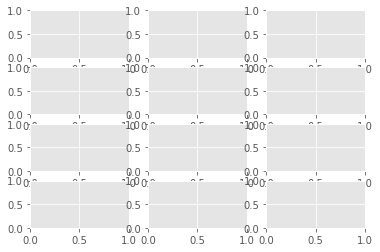

In [ ]:
clf_name = models[0][0] # the classifier name
clf = models[0][1] # the classifier itself

features = [0,1,2,3,4,5,6,7,8,9,10,11]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal on all features\n"
              "with {}".format(clf_name))
fig.set_size_inches(20, 10)
fig.subplots_adjust(hspace=.4, wspace=.25, top=.9)

In [ ]:
clf_name = models[0][0] # the classifier name
clf = models[0][1] # the classifier itself

features = [12,13,14,15,16,17,18,19,20]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal on all features\n"
              "with {}".format(clf_name))
fig.set_size_inches(20, 10)
fig.subplots_adjust(hspace=.4, wspace=.5, top=.9)

ValueError: ignored

In [ ]:
clf_name = models[0][0] # the classifier name
clf = models[0][1] # the classifier itself

features = [21,22,23,24,25,26,27,28,29]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal on all features\n"
              "with {}".format(clf_name))
fig.set_size_inches(20, 10)
fig.subplots_adjust(hspace=.4, wspace=.25, top=.9)

ValueError: ignored

In [ ]:
clf_name = models[0][0] # the classifier name
clf = models[0][1] # the classifier itself

features = [30,31,32,33,34,35,36,37,38]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal on all features\n"
              "with {}".format(clf_name))
fig.set_size_inches(20, 10)
fig.subplots_adjust(hspace=.4, wspace=.35, top=0.9)

ValueError: ignored

We could also plot a 2-way PDP, for example, visualizing the effect of the joint of `swin` and `ct_src_dport_itm` on the response by specifying a `tuple` that contains the indexes of them.

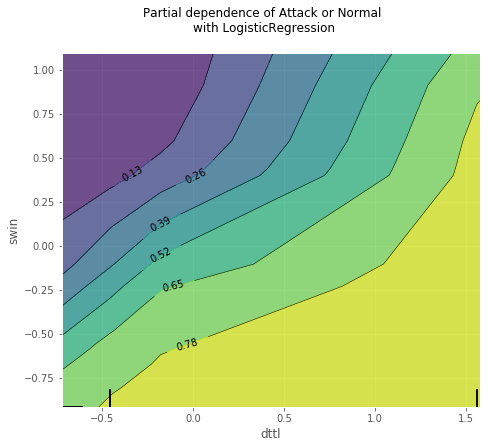

In [ ]:
features = [(7, 16)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal \n"
              "with {}".format(clf_name))
fig.set_size_inches(7.5, 6.5)
fig.subplots_adjust(hspace=0.3)
#We can do whatever we want in this code, cause our data features are too many, here just show one instance of top two features of permutation plots

We could also plot the one-way and two-way PDP together. 

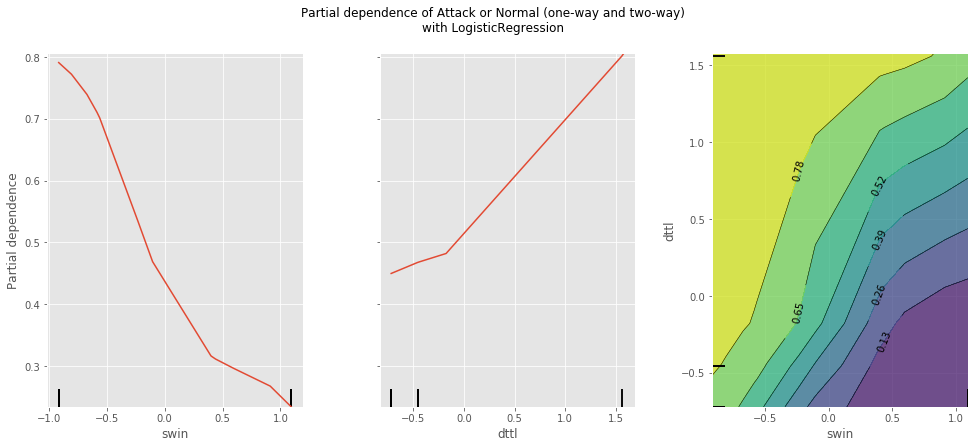

In [ ]:
features = [16, 7,(16, 7)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal (one-way and two-way)\n"
              "with {}".format(clf_name))
fig.set_size_inches(16.5, 6.5)
fig.subplots_adjust(wspace = 0.3)

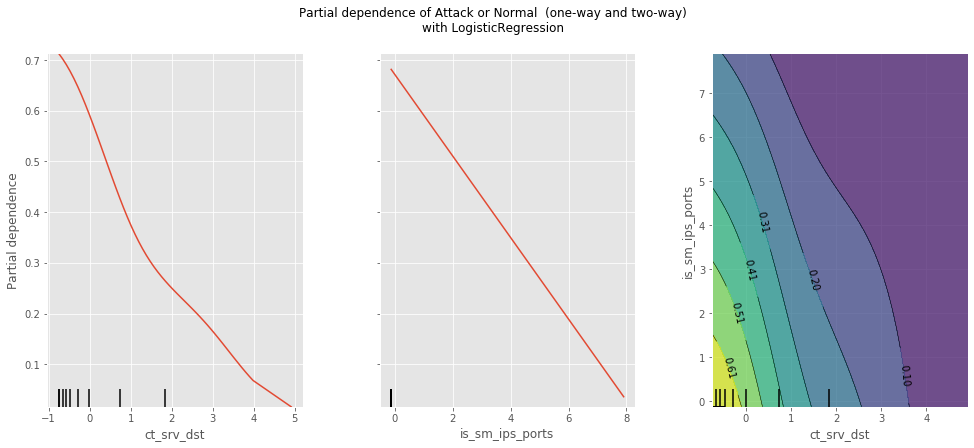

In [ ]:
features = [37, 38, (37, 38)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal  (one-way and two-way)\n"
              "with {}".format(clf_name))
fig.set_size_inches(16.5, 6.5)
fig.subplots_adjust(wspace = 0.3)

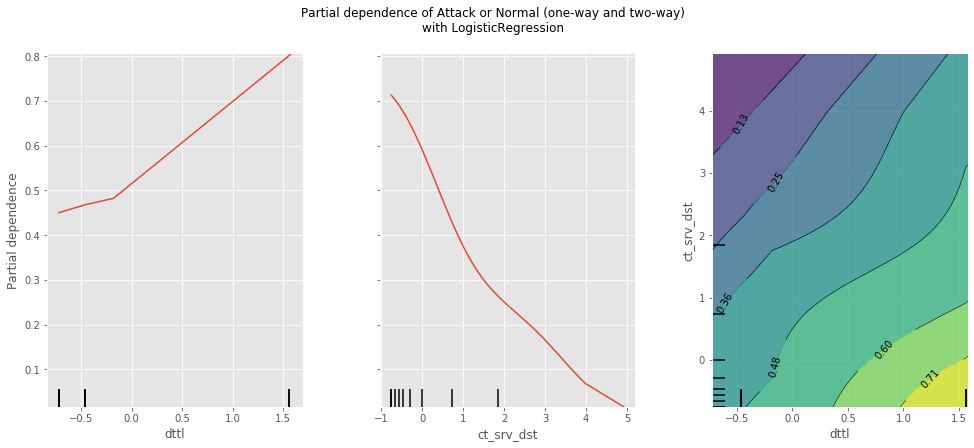

In [ ]:
features = [7, 37, (7,37)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal (one-way and two-way)\n"
              "with {}".format(clf_name))
fig.set_size_inches(16.5, 6.5)
fig.subplots_adjust(wspace = 0.3)

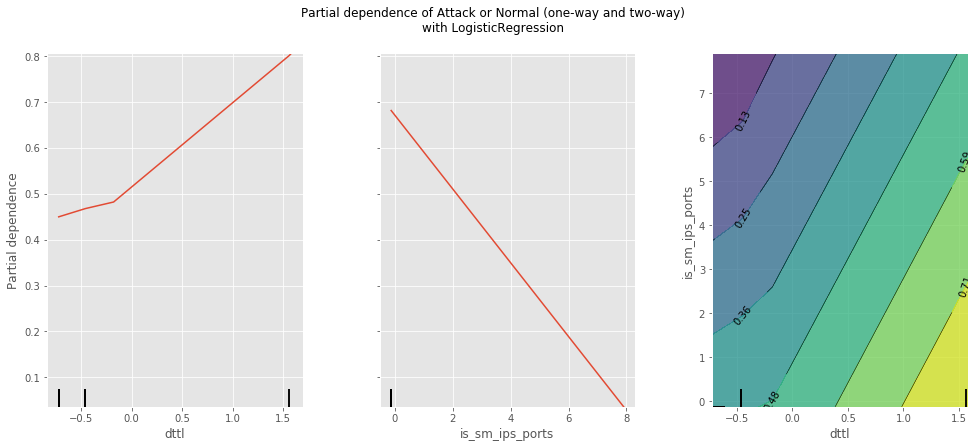

In [ ]:
features = [7, 38, (7,38)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal (one-way and two-way)\n"
              "with {}".format(clf_name))
fig.set_size_inches(16.5, 6.5)
fig.subplots_adjust(wspace = 0.3)

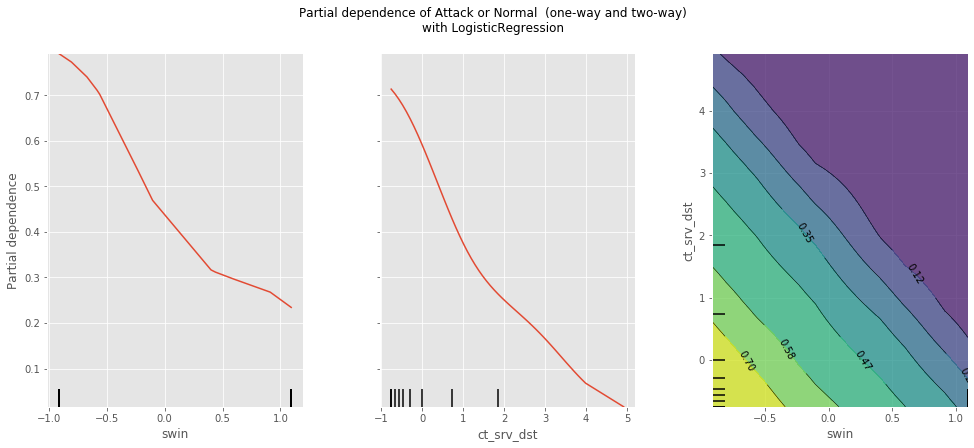

In [ ]:
features = [16, 37, (16,37)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal  (one-way and two-way)\n"
              "with {}".format(clf_name))
fig.set_size_inches(16.5, 6.5)
fig.subplots_adjust(wspace = 0.3)

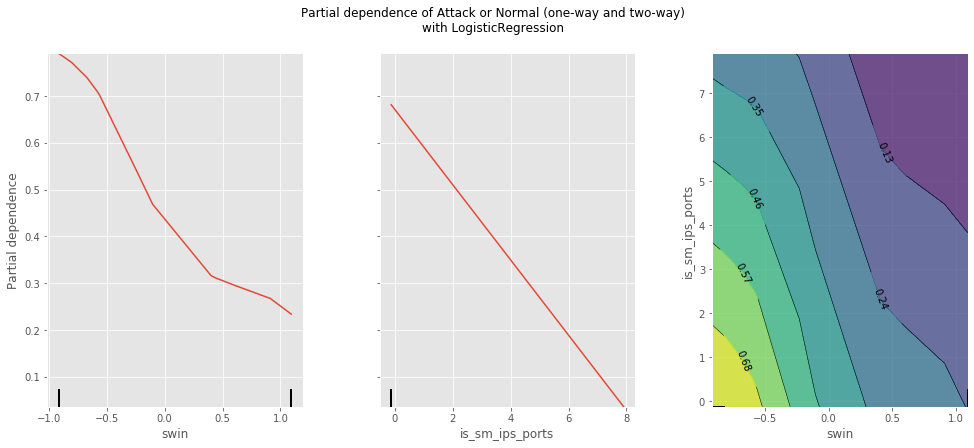

In [ ]:
features = [16, 38, (16,38)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal (one-way and two-way)\n"
              "with {}".format(clf_name))
fig.set_size_inches(16.5, 6.5)
fig.subplots_adjust(wspace = 0.3)

### Example: PDP for RandomTree
Let's plot the effect (one-way and two-way) for `RandomForest`.

In [ ]:
models[2]

('RandomForest',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=123,
                        verbose=0, warm_start=False))

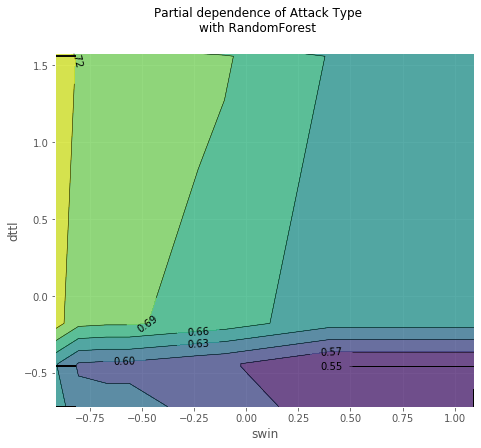

In [ ]:
clf_name = models[2][0]
clf = models[2][1]

features = [(16, 7)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack Type\n"
              "with {}".format(clf_name))
fig.set_size_inches(7.5, 6.5)
fig.subplots_adjust(hspace=0.3)

## Permutation Feature Importance 

Previous section shows that Partial Dependence Plots could present how a feature affects predictions. In this section, we focus on another basic question:  What features have the biggest impact on predictions?

This concept is called **feature importance**.

There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

We'll focus on **Permutation Feature Importance**. Compared to most other approaches, Permutation Feature Importance is:

- fast to calculate,
- widely used and understood, and
- consistent with properties we would want a feature importance measure to have.

The Permutation Feature Importance is defined to be the **decrease in a model score** when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. 

The above definition might be confused. Here is a clear example to show you how it works: https://www.kaggle.com/dansbecker/permutation-importance

In [ ]:
# import permutation function
from sklearn.inspection import permutation_importance

### Example: Permutation Feature Importance for Logistic Regression

#### Permutation Feature Importance on Training Data
Let's first plot the Permutation Feature Importance on **training data** with the trained Logistic Regression. 

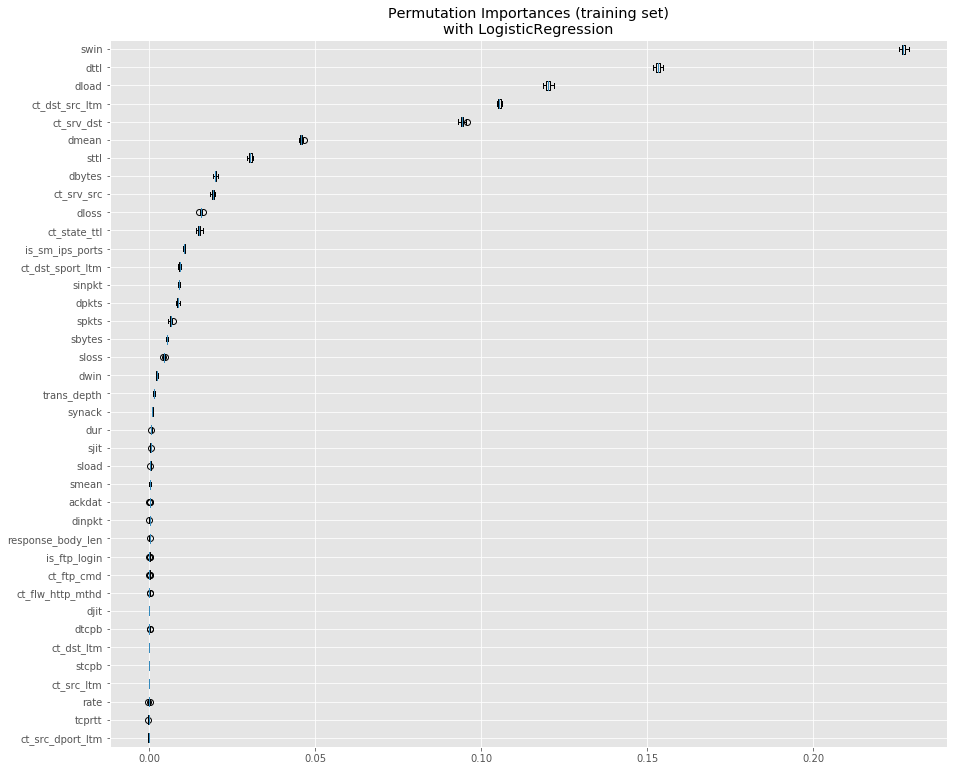

In [ ]:
clf_name = models[0][0]
clf = models[0][1]
result = permutation_importance(estimator=clf, 
                                X=X_train_transform, 
                                y=y2_train_transform, 
                                scoring="accuracy",
                                n_repeats=50,
                                random_state=123)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(new_cols)[sorted_idx])
ax.set_title("Permutation Importances (training set)\n"
            "with {}".format(clf_name))

fig.set_size_inches(15, 13)
plt.show()

**Interpretation**

- The values towards the top are the most important features, and those towards the bottom matter least.

- The values show how much model performance decreased with a random shuffling (in this case, using `accuracy` as the performance metric).

The above plot shows that `ct_src_dport_itm` is the most important feature in the Logistic Regression model because once we shuffle the `ct_src_dport_itm`` column of the training data, leaving the target and all other columns in place, the **decrease** of the `accuracy` score of predictions is around 0.24. This is significant finding.

#### Permutation Feature Importance on Hold-out Testing Data

Permutation importances can either be computed on the training set or an held-out testing or validation set. 
- Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. 

- Features that are important on the training set but not on the held-out set might cause the model to overfit.

Let's plot the Permutation Feature Importance on **hold-out testing data**

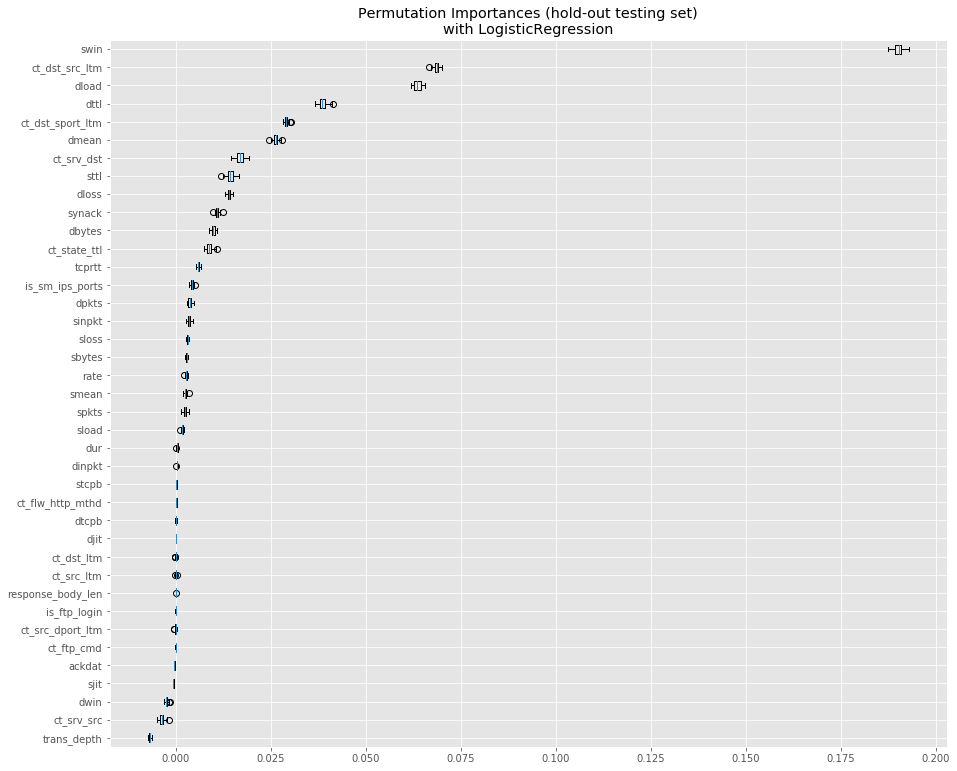

In [ ]:
result = permutation_importance(estimator=clf, 
                                X=X_test_transform, 
                                y=y2_test_transform, 
                                scoring="accuracy",
                                n_repeats=50,
                                random_state=123)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(new_cols)[sorted_idx])
ax.set_title("Permutation Importances (hold-out testing set)\n"
            "with {}".format(clf_name))
fig.set_size_inches(15, 13)

plt.show()